In [13]:
import numpy as np
import matplotlib.pyplot as plt 

In [14]:
coor_array=[]

long_coord = []
lat_coord = []

for i in range(2):
    long_coord.append(180*i)
for k in range(7):
    lat_coord.append(-15*k)

for lat in lat_coord:
    for long in long_coord:
        
        coor_array.append((long,lat))
        



In [ ]:
f=open('./GS4/GS4_Trace45')
lines = f.readlines()
numfiles = sum(1 for row in lines)
for i in range(numfiles):
    try:
        data = np.genfromtxt('/Users/camfoltz/Desktop/SRTFiles/DATA/GalacticScan1/Coordinate{}.dat'.format(i), dtype=float,
    delimiter="\t", autostrip=True,skip_header=1, names =True)
        
    except:
        print("no file")
        pass
    x =[data[i][0] for i in range(data.size)]
    y =[data[i][1] for i in range (data.size)]
    plt.plot(x,y)
    #plots red line in center frequency
    plt.axvline(x=1.4204e9, color ='r')
    plt.title("coor:{}, index:{}".format(coor_array[i],i) )
   # plt.ylim(.000016,.000021)
    plt.savefig("/Users/camfoltz/Desktop/SRTFiles/Plots/GalacticScan3/{},{}.png".format(coor_array[i],i),dpi=300)
    plt.show();

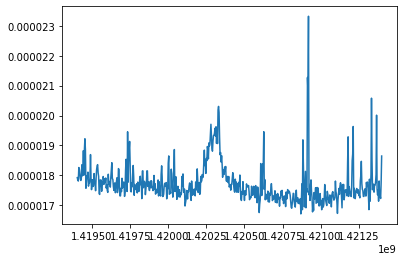

1.771824068333331e-05


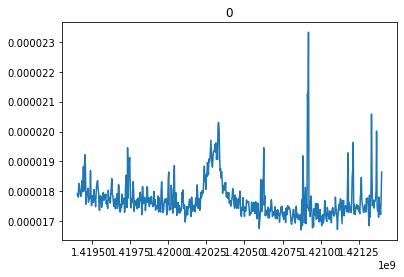

1.771824068333331e-05


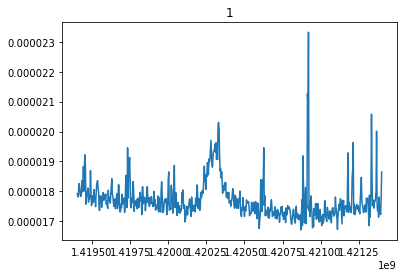

1.771824068333331e-05


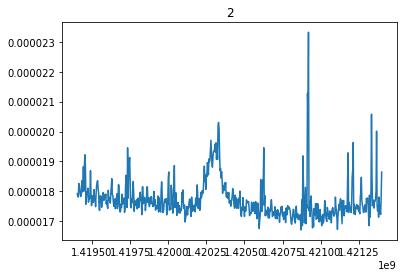

1.771824068333331e-05


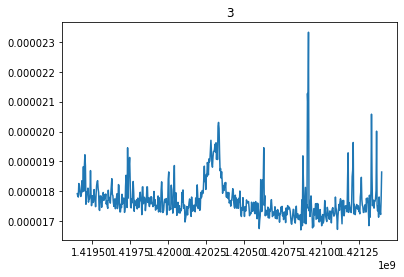

1.771824068333331e-05


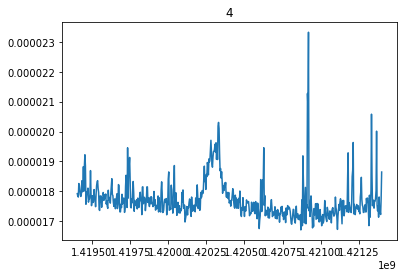

1.771824068333331e-05


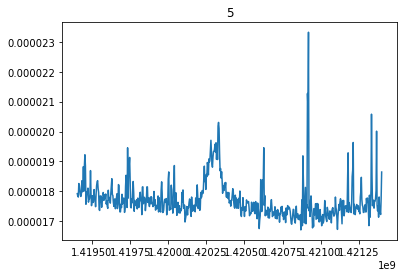

1.771824068333331e-05


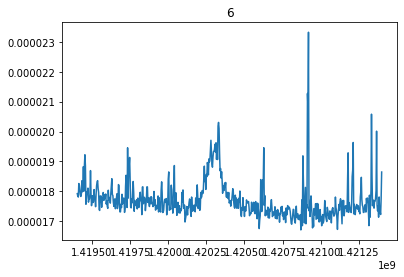

1.771824068333331e-05


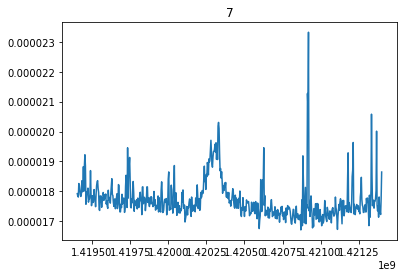

1.771824068333331e-05


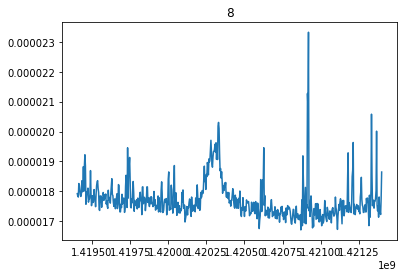

1.771824068333331e-05


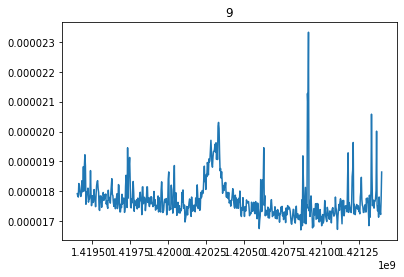

1.771824068333331e-05


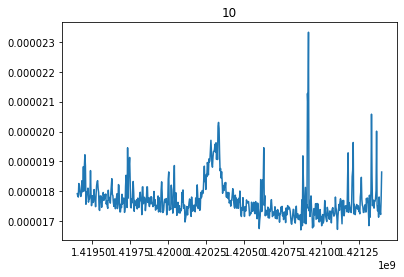

1.771824068333331e-05


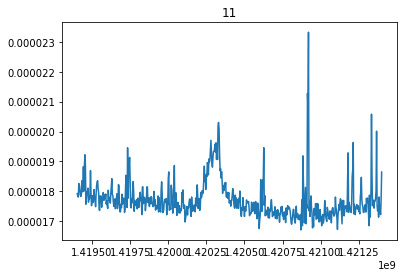

1.771824068333331e-05


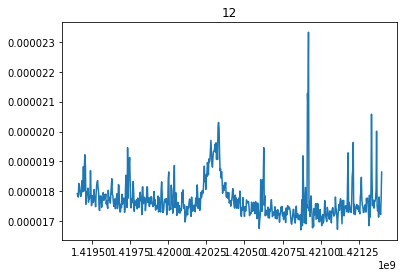

1.771824068333331e-05


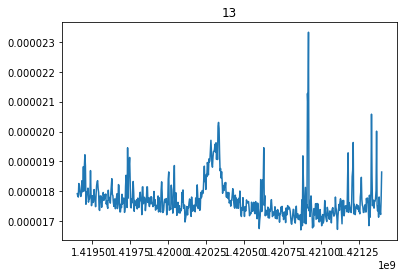

1.771824068333331e-05


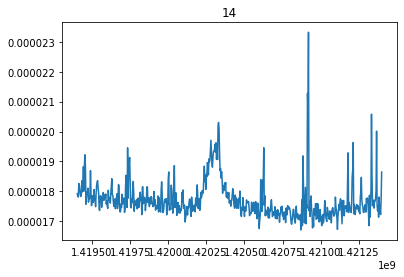

1.771824068333331e-05


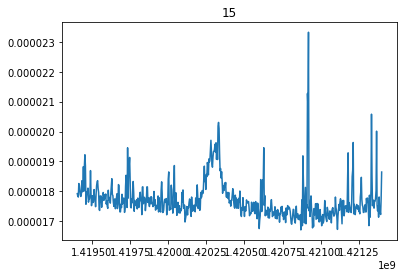

1.771824068333331e-05


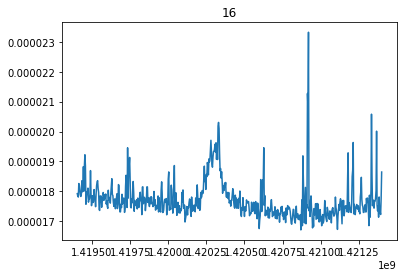

1.771824068333331e-05


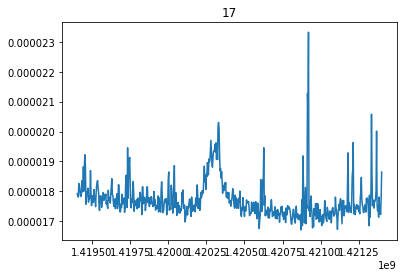

1.771824068333331e-05


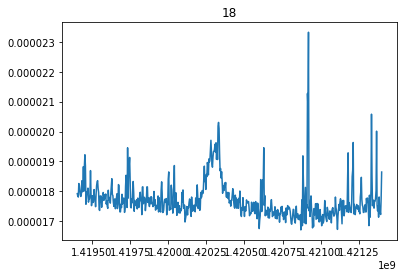

1.771824068333331e-05


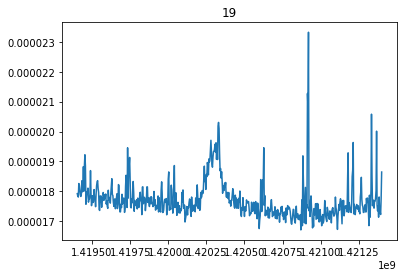

1.771824068333331e-05


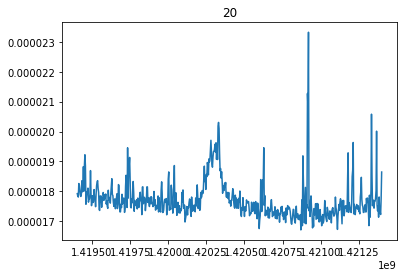

1.771824068333331e-05


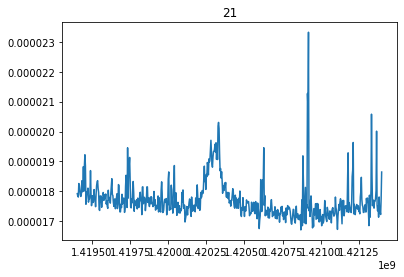

1.771824068333331e-05


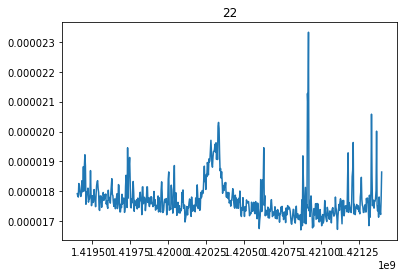

1.771824068333331e-05


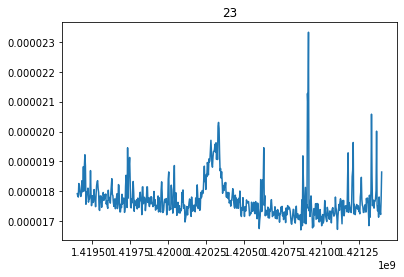

1.771824068333331e-05


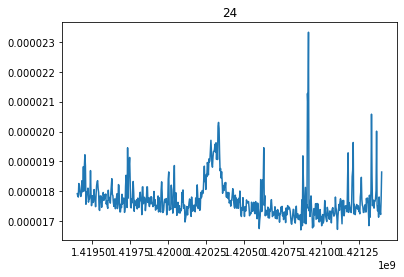

1.771824068333331e-05


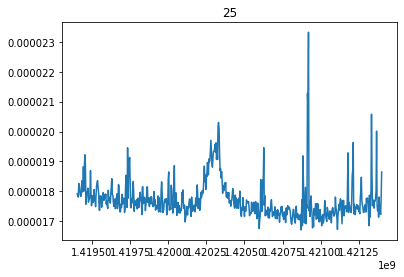

1.771824068333331e-05


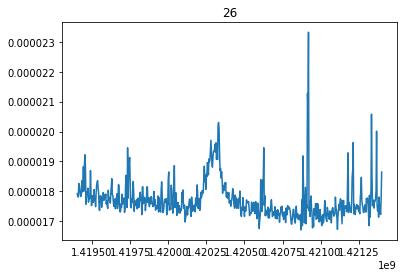

1.771824068333331e-05


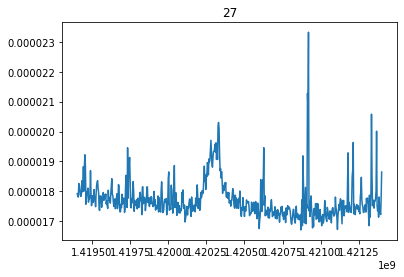

1.771824068333331e-05


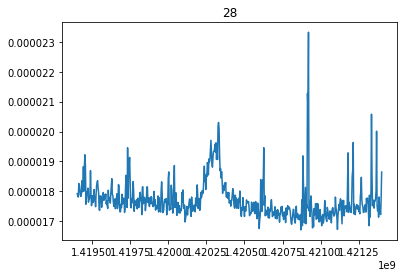

1.771824068333331e-05


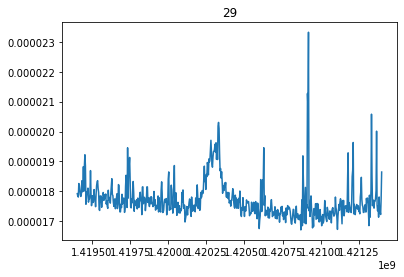

1.771824068333331e-05


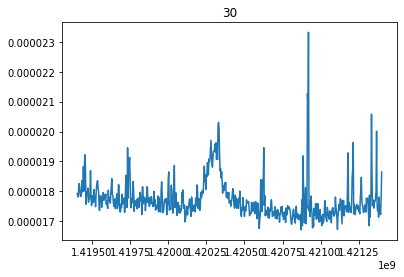

1.771824068333331e-05


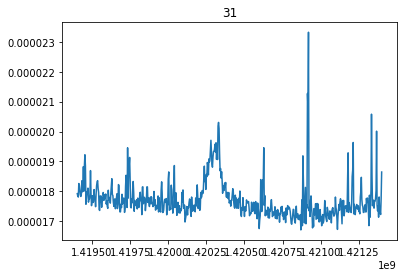

1.771824068333331e-05


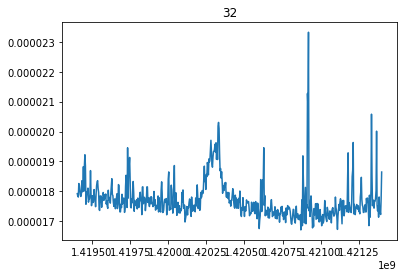

1.771824068333331e-05


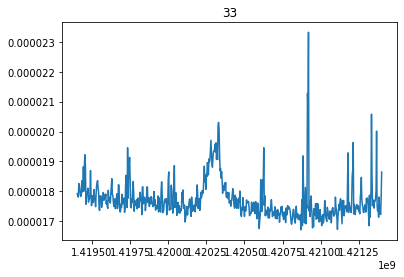

1.771824068333331e-05


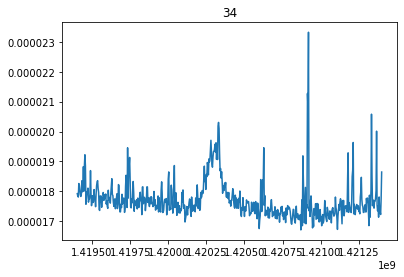

1.771824068333331e-05


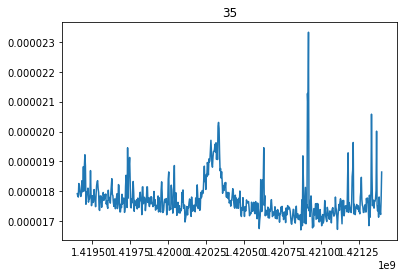

1.771824068333331e-05


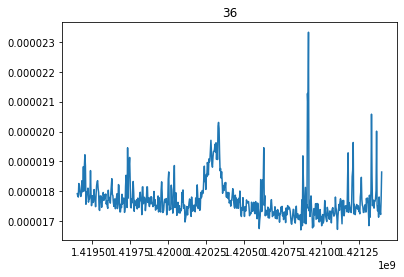

1.771824068333331e-05


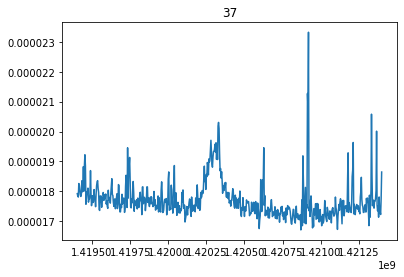

1.771824068333331e-05


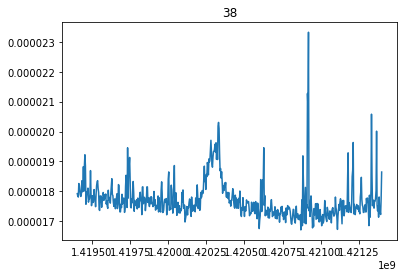

1.771824068333331e-05


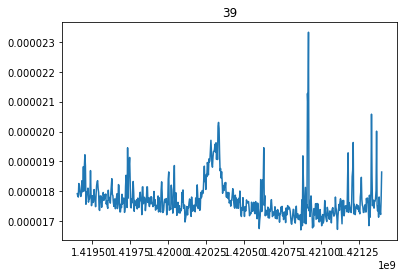

1.771824068333331e-05


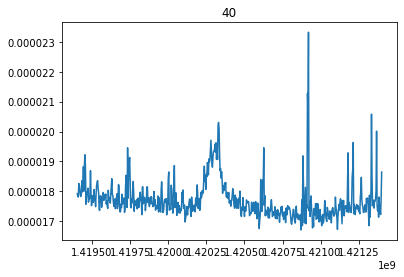

1.771824068333331e-05


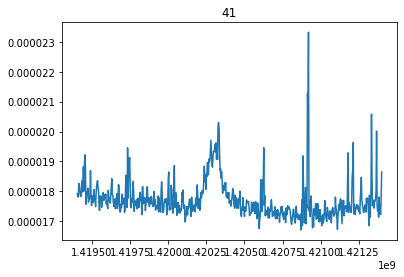

1.771824068333331e-05


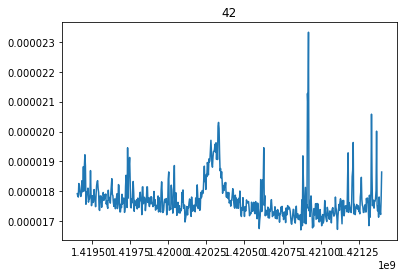

1.771824068333331e-05


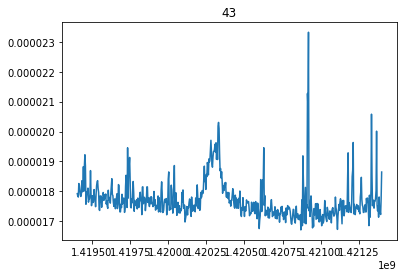

1.771824068333331e-05


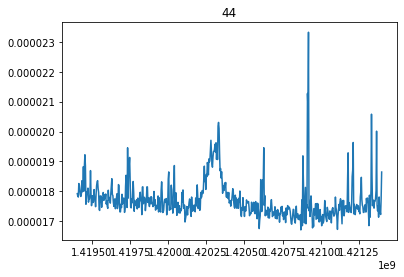

1.771824068333331e-05


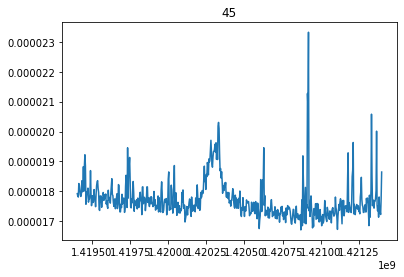

1.771824068333331e-05


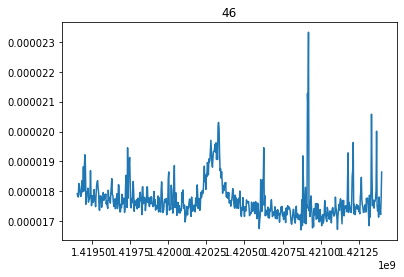

1.771824068333331e-05


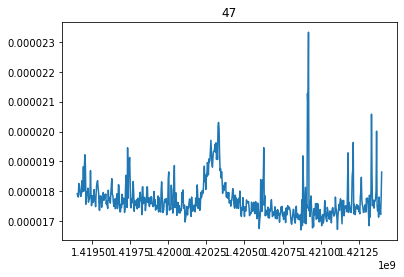

1.771824068333331e-05


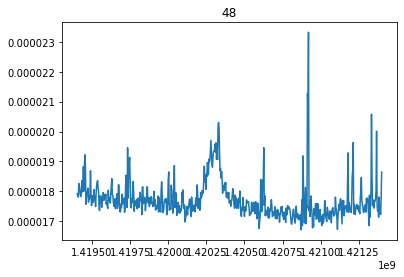

1.771824068333331e-05


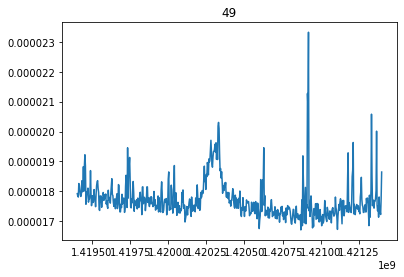

1.771824068333331e-05


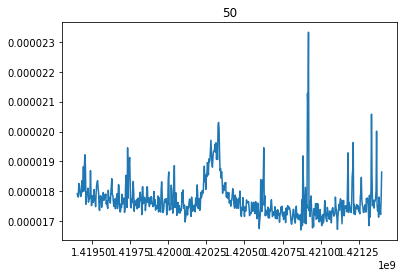

1.771824068333331e-05


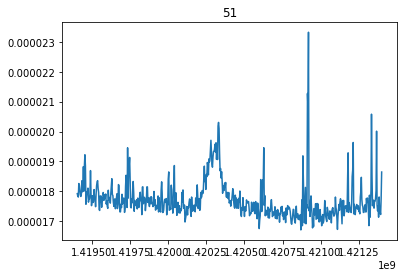

1.771824068333331e-05


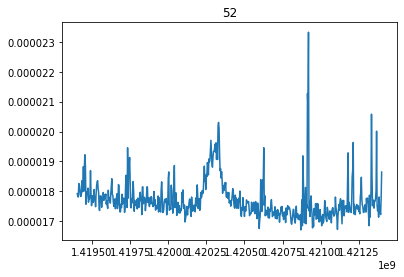

1.771824068333331e-05


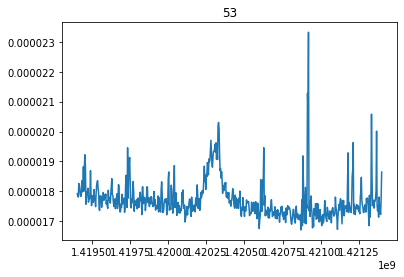

1.771824068333331e-05


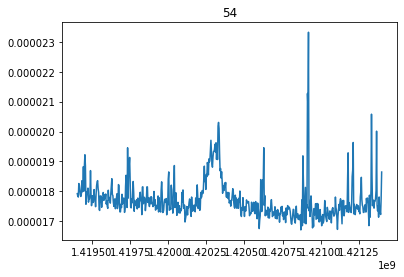

1.771824068333331e-05


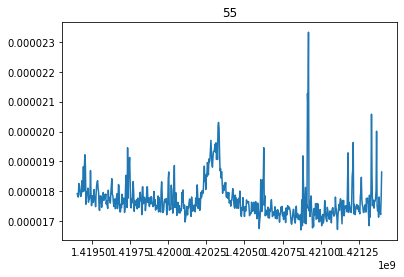

1.771824068333331e-05


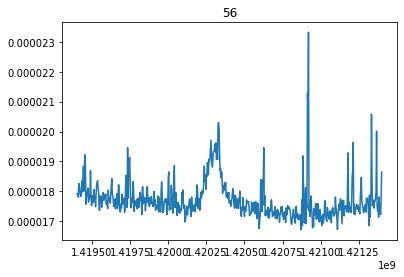

1.771824068333331e-05


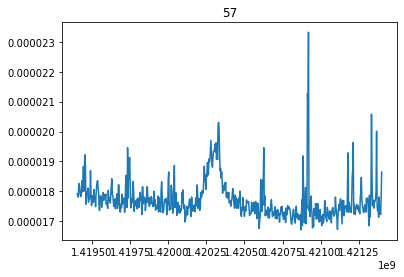

1.771824068333331e-05


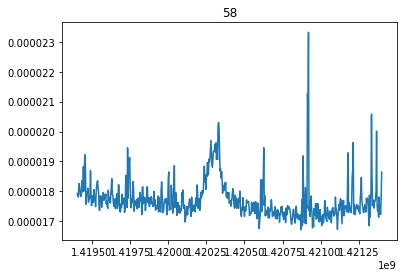

1.771824068333331e-05


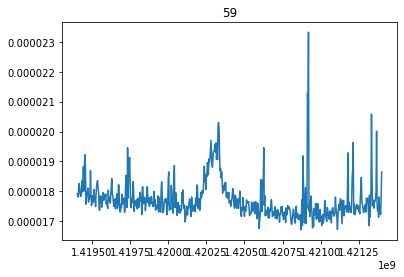

1.771824068333331e-05


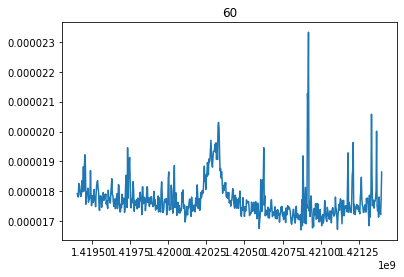

1.771824068333331e-05


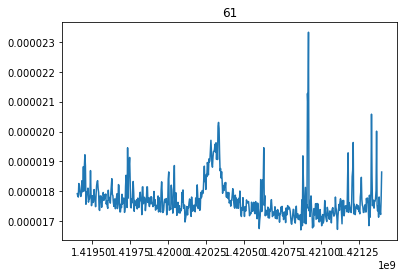

1.771824068333331e-05


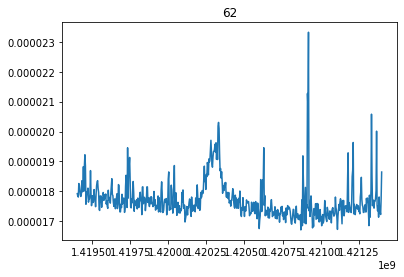

1.771824068333331e-05


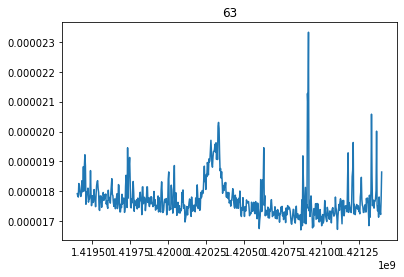

1.771824068333331e-05


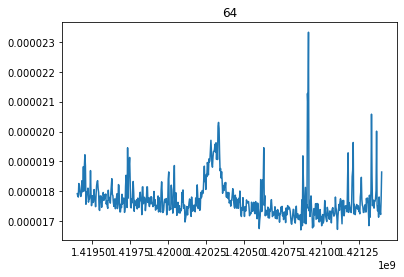

1.771824068333331e-05


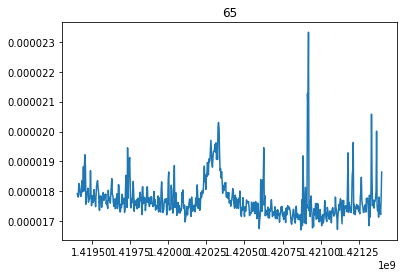

1.771824068333331e-05


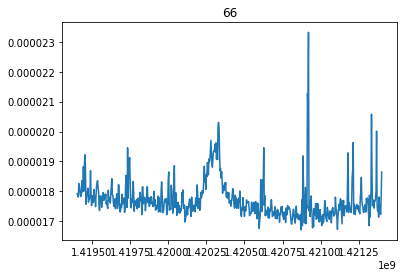

1.771824068333331e-05


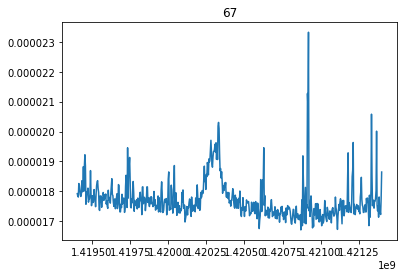

1.771824068333331e-05


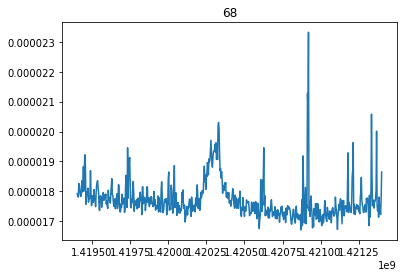

1.771824068333331e-05


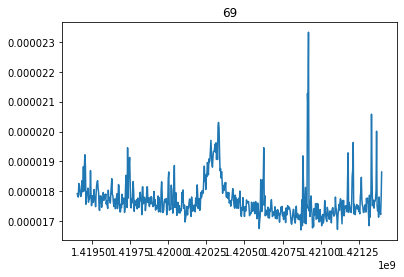

1.771824068333331e-05


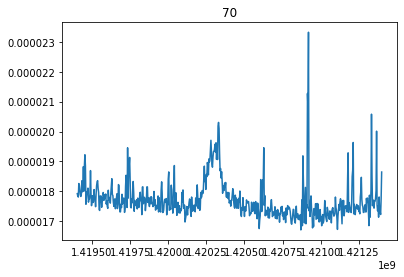

1.771824068333331e-05


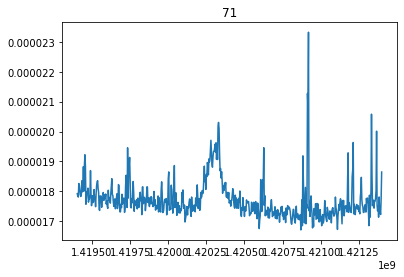

1.771824068333331e-05


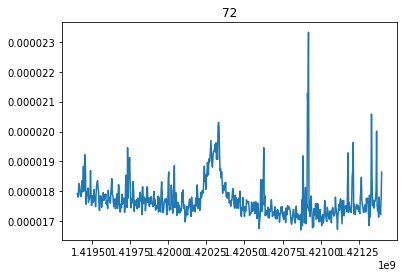

1.771824068333331e-05


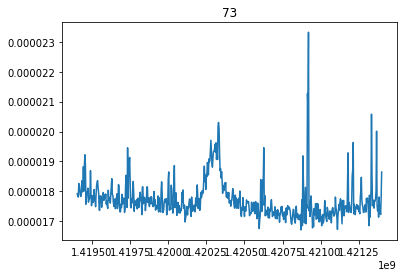

1.771824068333331e-05


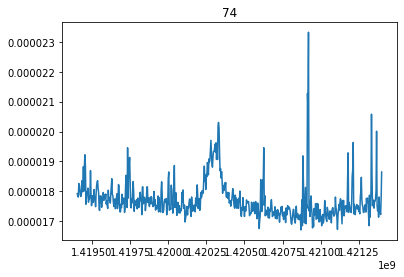

1.771824068333331e-05


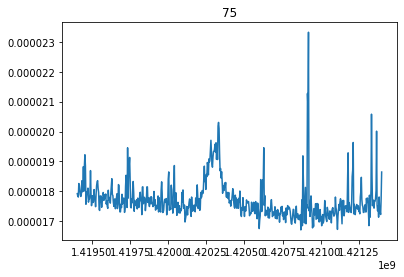

1.771824068333331e-05


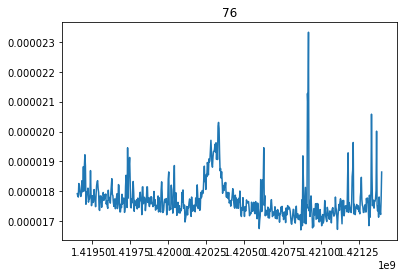

1.771824068333331e-05


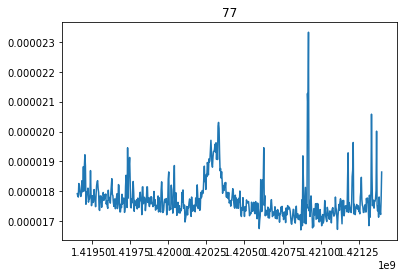

1.771824068333331e-05


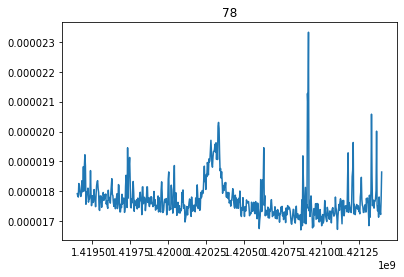

1.771824068333331e-05


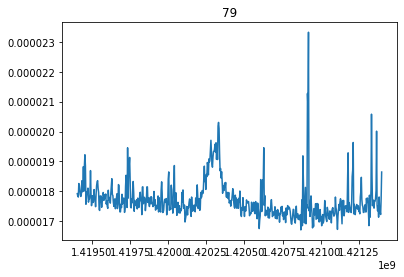

1.771824068333331e-05


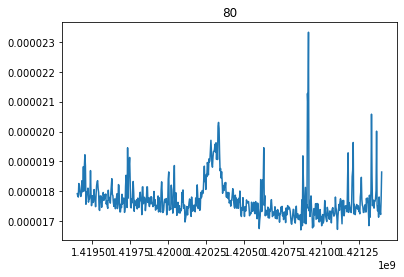

1.771824068333331e-05


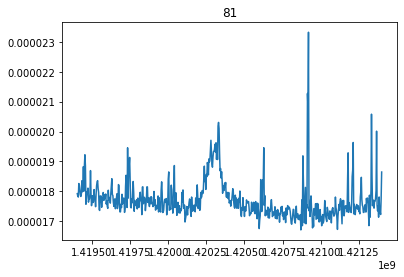

1.771824068333331e-05


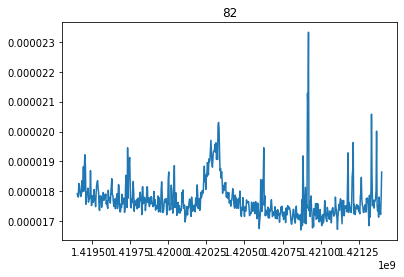

1.771824068333331e-05


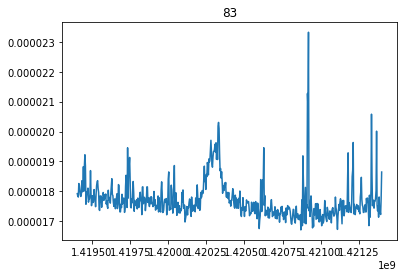

1.771824068333331e-05


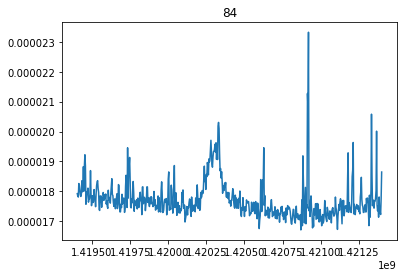

1.771824068333331e-05


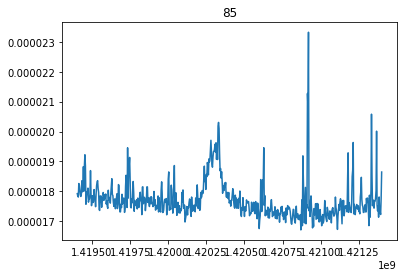

1.771824068333331e-05


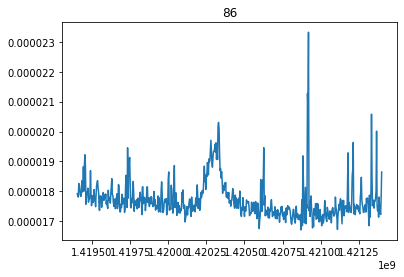

1.771824068333331e-05


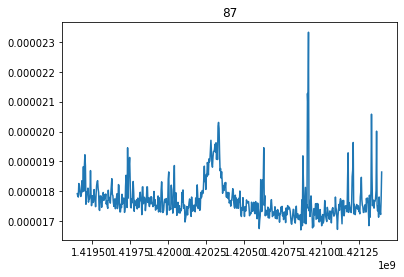

1.771824068333331e-05


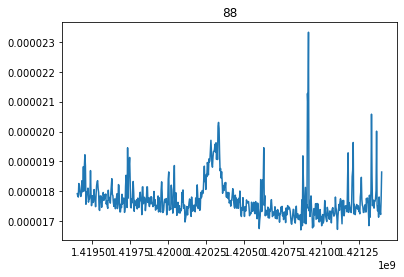

1.771824068333331e-05


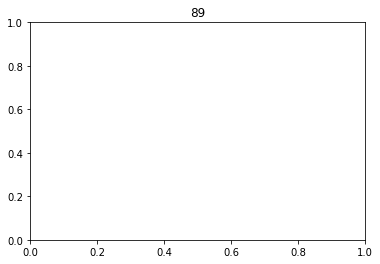

In [19]:
for i in range(90):
    data = np.genfromtxt('./GS4/GS4_Trace{}'.format(i), dtype=float,
    delimiter="\t", autostrip=True,skip_header=1, names =True)
    x =np.array([sunData[i][0] for i in range(data.size)])
    y =np.array([sunData[i][1] for i in range (data.size)])
    yAvg = np.array(sum((y)/len(y)))
    plt.plot(x,y)
    plt.show()
    plt.title(i)
    print(yAvg)

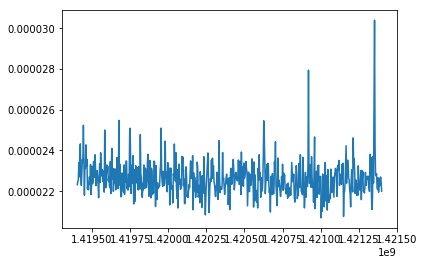

2.2611929449999994e-05


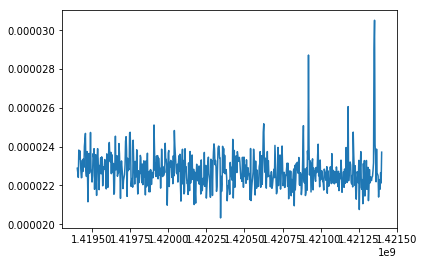

2.274545840000001e-05


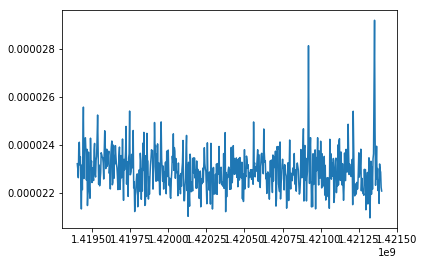

2.2922955100000013e-05


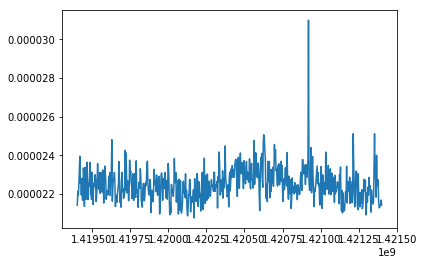

2.2496662499999978e-05


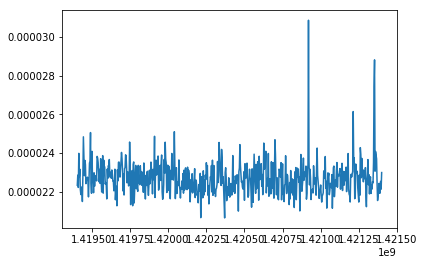

2.2699613283333335e-05


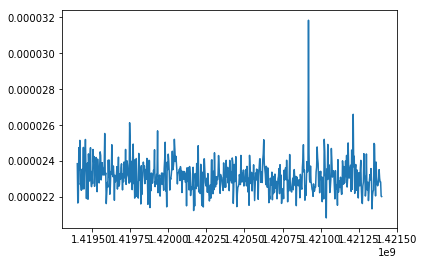

2.3133616383333307e-05


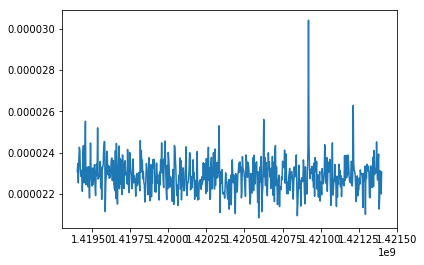

2.2870577550000005e-05


In [45]:
for i in range(7):
    sunData = np.genfromtxt('/Users/camfoltz/Desktop/SRTFiles/DATA/sunscan/Scan2_{}'.format(i), dtype=float,
    delimiter="\t", autostrip=True,skip_header=1, names =True)
    x =np.array([sunData[i][0] for i in range(data.size)])
    y =np.array([sunData[i][1] for i in range (data.size)])
    yAvg = np.array(sum((y)/len(y)))
    plt.plot(x,y)
    plt.show()
    print(yAvg)
    

# Finding proportionality constant from sun data

In [52]:
# Finding proportionality constant from sun data
sunAmp = 2.3133616383333307e-05
TSun = 100000
viewSRT = .016
viewSun = 6.8e-5
TempPropConstant = (sunAmp*viewSRT)/(TSun*viewSun)
print(TempPropConstant)

5.4432038549019545e-08


In [50]:
(2.82-1)/2

0.9099999999999999

In [53]:
1.9e-5/TempPropConstant

349.05912963170175